In [186]:
import cv2

# Setup Haar Cascade (Deteksi Wajah)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [187]:
# Fungsi Augmentasi
def augment_image(img):
    augmented = []
    augmented.append(img)  # Original
    augmented.append(cv2.flip(img, 1))  # Flip Horizontal
    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), 10, 1)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    augmented.append(rotated)  # Rotated
    return augmented

In [188]:
import glob
import cv2
import numpy as np

from skimage.feature import hog

# Fungsi Load & Preprocessing Data
def load_and_preprocess(folder_paths):
    X = []
    y = []
    for label, folder in enumerate(folder_paths):
        images = glob.glob(folder + '/*.jpg')
        for img_path in images:
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)

            for (x, y_, w, h) in faces:
                roi = gray[y_:y_+h, x:x+w]

                # Augmentasi
                for face_aug in augment_image(roi):
                    face_aug = cv2.resize(face_aug, (42, 42))

                    # Ekstraksi fitur HOG
                    hog_features = hog(face_aug, orientations=9, pixels_per_cell=(8, 8),
                                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

                    X.append(hog_features)
                    y.append(label)
                break  # satu wajah per gambar
    return np.array(X), np.array(y)

In [189]:
def load_and_convert_gray(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [190]:
def detect_face_roi(gray_img):
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    if len(faces) == 0:
        return None
    (x, y, w, h) = faces[0]
    roi = gray_img[y:y+h, x:x+w]
    roi_resized = cv2.resize(roi, (42, 42))
    return roi_resized

In [191]:
from skimage.feature import hog
from skimage import exposure

def get_hog_features(image):
    features, hog_image = hog(image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              block_norm='L2-Hys',
                              visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return features, hog_image_rescaled

In [192]:
import matplotlib.pyplot as plt

def visualize_all(original_img, roi_gray, hog_image, hog_features):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Grayscale + ROI")
    plt.imshow(roi_gray, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("HOG Visualization")
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Flattened HOG Features")
    plt.plot(hog_features)
    plt.tight_layout()
    plt.show()

In [193]:
def run_full_pipeline(img_path):
    original, gray = load_and_convert_gray(img_path)
    roi = detect_face_roi(gray)
    if roi is None:
        print("No face detected.")
        return
    features, hog_img = get_hog_features(roi)
    visualize_all(original, roi, hog_img, features)


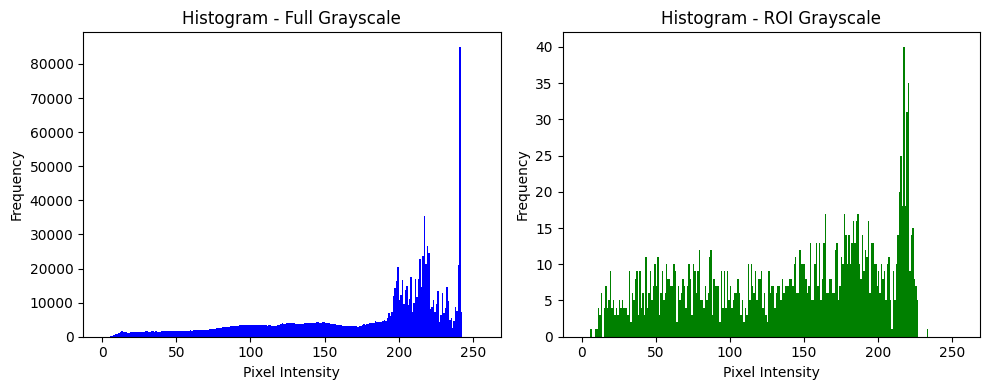

In [194]:
import matplotlib.pyplot as plt

img_ori_ex, img_gray_ex = load_and_convert_gray('./dataset/senang/05-12-21-happy-people.jpg')
img_roi_ex = detect_face_roi(img_gray_ex)

# Visualisasi Histogram
def visualize_histograms(full_gray, roi_gray):
    plt.figure(figsize=(10, 4))

    # Histogram gambar grayscale penuh
    plt.subplot(1, 2, 1)
    plt.title("Histogram - Full Grayscale")
    plt.hist(full_gray.ravel(), bins=256, range=[0, 256], color='blue')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # Histogram ROI grayscale
    plt.subplot(1, 2, 2)
    plt.title("Histogram - ROI Grayscale")
    plt.hist(roi_gray.ravel(), bins=256, range=[0, 256], color='green')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

visualize_histograms(img_gray_ex, img_roi_ex)

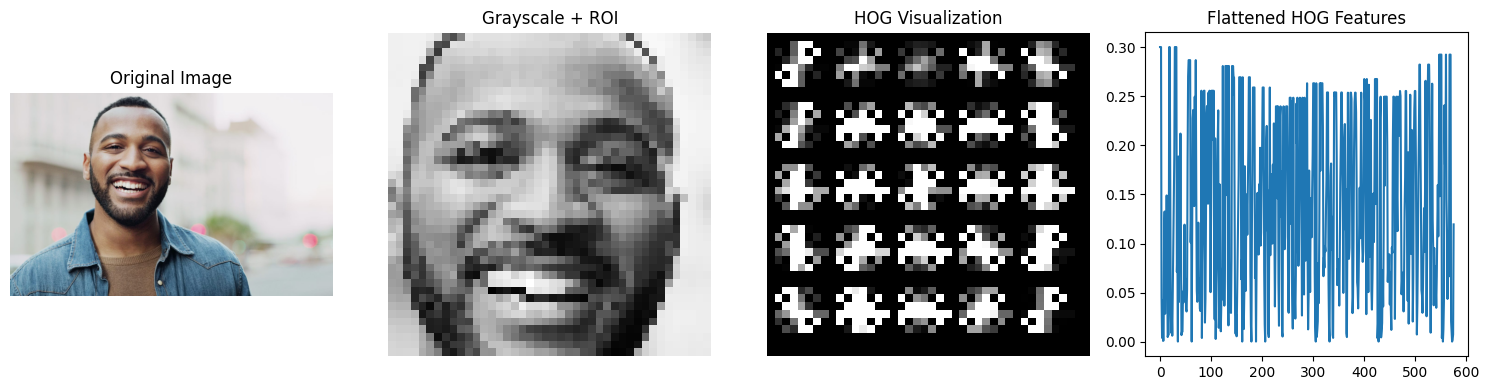

In [195]:
# Hasil Visualisasi Salah Satu Gambar
run_full_pipeline('./dataset/senang/05-12-21-happy-people.jpg')

In [196]:
# Load Dataset
folder_paths = ['dataset/senang', 'dataset/marah']  # ganti sesuai folder dataset lu
X, y = load_and_preprocess(folder_paths)
print(f'Dataset shape after augmentasi: {X.shape}')

Dataset shape after augmentasi: (270, 576)


In [197]:
from sklearn.model_selection import train_test_split

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
from sklearn.preprocessing import StandardScaler

# Normalisasi Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [199]:
from sklearn.svm import SVC

# Initialize SVM
svm_rbf = SVC(kernel='rbf', gamma='scale', probability=True)

In [200]:
# Train Data (RBF)
svm_rbf.fit(X_train, y_train)

SVC(probability=True)

In [201]:
# Testing (RBF)
y_pred_rbf = svm_rbf.predict(X_test)

In [202]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\n==== HASIL RBF SVM ====")
print("Accuracy:", accuracy_score(y_test, y_pred_rbf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


==== HASIL RBF SVM ====
Accuracy: 0.9259259259259259
Confusion Matrix:
 [[24  2]
 [ 2 26]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.93      0.93      0.93        28

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54



In [203]:
from sklearn.decomposition import PCA

# Reduksi Dimensi ke 2D untuk visualisasi
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Train ulang di space 2D
svm_2d = SVC(kernel='rbf', gamma='scale', probability=True)
svm_2d.fit(X_train_2d, y_train)

SVC(probability=True)

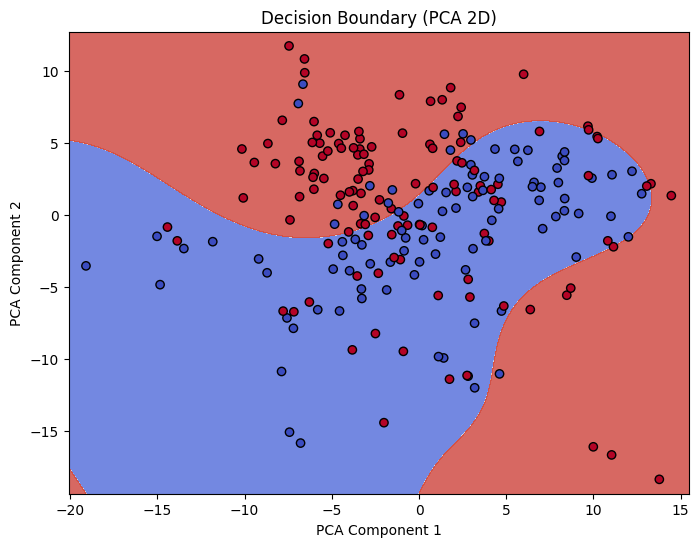

In [204]:
# Visualisasi Decision Boundary
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y):
    h = .02  # step size in mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Decision Boundary (PCA 2D)')
    plt.show()

plot_decision_boundary(svm_2d, X_train_2d, y_train)


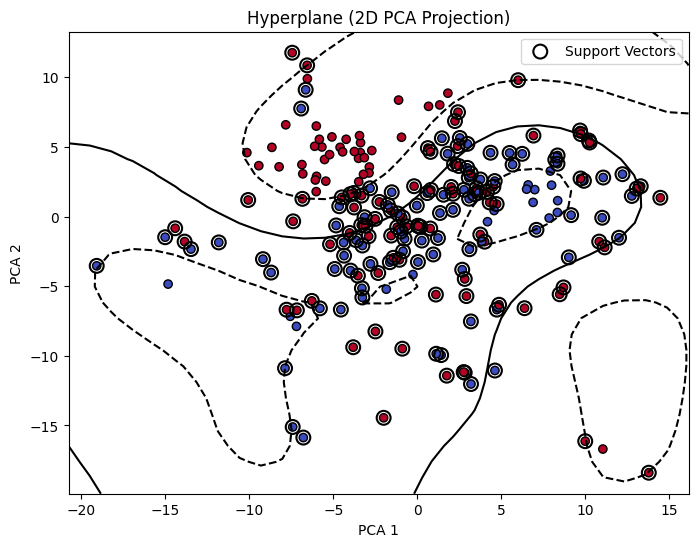

In [205]:
def plot_svm_hyperplane(clf, X, y):
    plt.figure(figsize=(8,6))

    # Plot data
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

    # Plot support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')

    # Buat grid untuk decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary dan margin
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
               linestyles=['--', '-', '--'])

    plt.title("Hyperplane (2D PCA Projection)")
    plt.legend()
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()

plot_svm_hyperplane(svm_2d, X_train_2d, y_train)


In [206]:
import pandas as pd

# Ubah bentuk label ke dalam bentuk class
label_names = ["senang", "marah"]
label_str = list(map(lambda idx: label_names[idx], y))

# Simpan fitur ke dalam DataFrame
df = pd.DataFrame(X)
df['label'] = label_str  # tambahin kolom label

# Simpan ke Excel
df.to_excel('extraction_features_HOG.xlsx', index=False)
print("Fitur berhasil disimpan ke 'extraction_features_HOG.xlsx'")

Fitur berhasil disimpan ke 'extraction_features_HOG.xlsx'


In [207]:
import pandas as pd
from sklearn.decomposition import PCA

# Jalankan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Buat DataFrame
df_pca = pd.DataFrame({
    'PCA_1': X_pca[:, 0],
    'PCA_2': X_pca[:, 1],
    'Label': y
})

# Simpan ke Excel
df_pca.to_excel('scatter_plot_data.xlsx', index=False)


In [208]:
import pickle

# Simpan model dalam bentuk "*.pkl"
with open("model_svm.pkl", "wb") as f :
    pickle.dump(svm_rbf, f)

print("Model berhasil di simpan ke dalam model_svm.pkl")

Model berhasil di simpan ke dalam model_svm.pkl
